This is the Assignment of **De Montfort University**.

---

Here are the details:

Student Name: **Karan Falgun Modi**.

PNumber: P2761604

---

This file Containes  the first part of the assignment which is Data Exploration, Data Vizulization and Analytics(Using Apache Spark)


---

Here are the Steps:
1. Loading and PreProcessing Data (Step 1 to 6)
  > Step 1 : Initialized Spark Session.
  
  > Step 2 : Load the Dataset.
  
  > Step 3 : Combined all Data into one Dataframe.
  
  > Step 4 : Verified PrintSchema and Counted combined dataframe rows.

  > Step 5 : Inserted County Names based on Reported by (Police force) names into county column.

  > Step 6 : Verifications.

2. Descriptive Data Analysis using Spark SQL (Step 7 to 10)
  > Step 7 : Creation of Temporary SQL View called crime_date

  > Step 8 : Data Analysis : Total Crimes by County

  > Step 9 : Data Analysis : Crime type Analysis with Frequency

  > step 10 : Data Analysis : Monthly Crime Trends

3. Data Visualization (Step 11 to 14)

  > step 11 : Imported Libraries for Data Visulizations
  
  > step 12 : Line plot for Monthly Crime Trends

  > Step 13 : Bar chart for crime type comparison

  > Step 14 : Pie charts for crime type breakdown by county


## THE END of PART A.

# Task 1 : Loading and PreProcessing Data

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit, when, col, countDistinct, count, to_date
import os

# Step 1 : Initialized Spark Session
spark = SparkSession.builder.master("local[*]").appName("Crime_Data_Analysis_2022").getOrCreate()

In [2]:
# Step 2 : Load the Dataset

# Provided the path of the folder where the Dataset exist in a CSV files.
CrimeDataset = "/content/CrimeDataset"

#Combined_CrimeDataset Created which is empty.
combined_df = None


In [3]:
# Step 3 : Combined all Data into one Dataframe

# Iterate over each file in the dataset folder
for file in os.listdir(CrimeDataset):
  file_path = os.path.join(CrimeDataset,file)

  #Created a column named County and load the files into a dataframe.
  df = spark.read.option("header", "true").csv(file_path, inferSchema=True)

  # Combine the data
  combined_df = df if combined_df is None else combined_df.union(df)

In [4]:
# Step 4 : Verified PrintSchema and Counted combined dataframe rows.

# Show the schema and a sample of the combined DataFrame
combined_df.printSchema()
combined_df.count()

root
 |-- Crime ID: string (nullable = true)
 |-- Month: timestamp (nullable = true)
 |-- Reported by: string (nullable = true)
 |-- Falls within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA code: string (nullable = true)
 |-- LSOA name: string (nullable = true)
 |-- Crime type: string (nullable = true)
 |-- Last outcome category: string (nullable = true)
 |-- Context: string (nullable = true)



426929

In [5]:
# Step 5 : Inserted County Names based on Reported by (Police force) names into county column

# Create a mapping dictionary for standardizing county names
county_mapping = {
    "Derbyshire Constabulary" : "Derbyshire",
    "Leicestershire Police" : "Leicestershire",
    "Kent Police" : "Kent"
}

# Convert dictionary keys to a list for Spark compatibility
county_keys_list = list(county_mapping.keys())

# Update the County column using the Reported by column
combined_df = combined_df.withColumn(
    "County",
    when(col("Reported by").isin(county_keys_list), col("Reported by")).otherwise(lit(None))
    )

# Replace Reported_By(police force) names with standardized county names
for Reported_by, county in county_mapping.items():
    combined_df = combined_df.withColumn(
        "County",
        when(col("County") == Reported_by, lit(county)).otherwise(col("County"))
    )



In [6]:
# Step 6 : Verification
combined_df.show(5)

+--------------------+-------------------+--------------------+--------------------+---------+---------+--------------------+---------+-----------------+--------------------+---------------------+-------+----------+
|            Crime ID|              Month|         Reported by|        Falls within|Longitude| Latitude|            Location|LSOA code|        LSOA name|          Crime type|Last outcome category|Context|    County|
+--------------------+-------------------+--------------------+--------------------+---------+---------+--------------------+---------+-----------------+--------------------+---------------------+-------+----------+
|                NULL|2022-03-01 00:00:00|Derbyshire Consta...|Derbyshire Consta...|-1.376752|53.101034|On or near Meadow...|E01019400|Amber Valley 001A|Anti-social behav...|                 NULL|   NULL|Derbyshire|
|                NULL|2022-03-01 00:00:00|Derbyshire Consta...|Derbyshire Consta...|-1.375369|53.099579|On or near Priory...|E01019400|A

In [7]:
# Step 6 : Verification

# Filter the DataFrame to show only Leicestershire data
filtered_Leicestershire = combined_df.filter((combined_df.County == "Leicestershire"))
filtered_Leicestershire.show(5)

+--------------------+-------------------+--------------------+--------------------+---------+---------+--------------------+---------+----------+--------------------+---------------------+-------+--------------+
|            Crime ID|              Month|         Reported by|        Falls within|Longitude| Latitude|            Location|LSOA code| LSOA name|          Crime type|Last outcome category|Context|        County|
+--------------------+-------------------+--------------------+--------------------+---------+---------+--------------------+---------+----------+--------------------+---------------------+-------+--------------+
|                NULL|2022-02-01 00:00:00|Leicestershire Po...|Leicestershire Po...| -1.21556|52.619443|On or near Lancel...|E01025631|Blaby 002A|Anti-social behav...|                 NULL|   NULL|Leicestershire|
|848e8a6bf17e4e401...|2022-02-01 00:00:00|Leicestershire Po...|Leicestershire Po...|-1.212224| 52.62343|On or near Willou...|E01025631|Blaby 002A|Vi

In [8]:
# Step 6 : Verification

distinct_counties = combined_df.select("Reported by", "County").distinct()

# Display the first 3 distinct rows for verification
distinct_counties.show(3)

+--------------------+--------------+
|         Reported by|        County|
+--------------------+--------------+
|Derbyshire Consta...|    Derbyshire|
|Leicestershire Po...|Leicestershire|
|         Kent Police|          Kent|
+--------------------+--------------+



In [9]:
# Step 6 : Verification

# Filter the DataFrame to show only Kent data
filtered_Kent = combined_df.filter((combined_df.County == "Kent"))
filtered_Kent.show(5)

+--------------------+-------------------+-----------+------------+---------+---------+--------------------+---------+------------+--------------------+---------------------+-------+------+
|            Crime ID|              Month|Reported by|Falls within|Longitude| Latitude|            Location|LSOA code|   LSOA name|          Crime type|Last outcome category|Context|County|
+--------------------+-------------------+-----------+------------+---------+---------+--------------------+---------+------------+--------------------+---------------------+-------+------+
|b93c5583a3adce8a0...|2022-08-01 00:00:00|Kent Police| Kent Police| 0.973355|51.260972|On or near Lower ...|E01023987|Ashford 001B|            Burglary| Investigation com...|   NULL|  Kent|
|330e17b2dc5af6854...|2022-08-01 00:00:00|Kent Police| Kent Police| 0.963316|51.258906|On or near New Fo...|E01023987|Ashford 001B|Criminal damage a...| Investigation com...|   NULL|  Kent|
|794686e451d00c2c8...|2022-08-01 00:00:00|Kent Pol

In [10]:
# Step 6 : Verification

# Filter the DataFrame to show only Derbyshire data
filtered_Derbyshire = combined_df.filter((combined_df.County == "Derbyshire"))
filtered_Derbyshire.show(5)

+--------------------+-------------------+--------------------+--------------------+---------+---------+--------------------+---------+-----------------+--------------------+---------------------+-------+----------+
|            Crime ID|              Month|         Reported by|        Falls within|Longitude| Latitude|            Location|LSOA code|        LSOA name|          Crime type|Last outcome category|Context|    County|
+--------------------+-------------------+--------------------+--------------------+---------+---------+--------------------+---------+-----------------+--------------------+---------------------+-------+----------+
|                NULL|2022-03-01 00:00:00|Derbyshire Consta...|Derbyshire Consta...|-1.376752|53.101034|On or near Meadow...|E01019400|Amber Valley 001A|Anti-social behav...|                 NULL|   NULL|Derbyshire|
|                NULL|2022-03-01 00:00:00|Derbyshire Consta...|Derbyshire Consta...|-1.375369|53.099579|On or near Priory...|E01019400|A

In [11]:
# Step 6 : Verification

# Perform detailed checks to ensure data integrity
row_count = combined_df.count()
unique_counties = combined_df.select(countDistinct("County")).collect()[0][0]
print(f"Total number of rows: {row_count}")
print(f"Number of unique counties: {unique_counties}")

# Ensure the DataFrame contains the full dataset for 2022, including all months and counties
if unique_counties == 3:
    print("All expected counties are present.")
else:
    print("Warning: Some expected counties might be missing.")


Total number of rows: 426929
Number of unique counties: 3
All expected counties are present.


# Task 2 : Descriptive Data Analysis using Spark SQL

In [12]:
# Step 7 : Creation of Temporary SQL View called crime_date

#  Created a temporary SQL view.
combined_df.createOrReplaceTempView("crime_data")

In [13]:
# Step 8 : Data Analysis : Total Crimes by County

total_crimes_by_county = spark.sql(
    """
    SELECT County, COUNT(*) AS Total_Crimes
    FROM crime_data
    WHERE County IS NOT NULL
    GROUP BY County
    ORDER BY Total_Crimes DESC
    """
)
total_crimes_by_county.show()


+--------------+------------+
|        County|Total_Crimes|
+--------------+------------+
|          Kent|      200945|
|Leicestershire|      115179|
|    Derbyshire|      110805|
+--------------+------------+



In [14]:
# Step 9 : Data Analysis : Crime type Analysis with Frequency

crime_type_analysis = spark.sql(
    """
    SELECT County, `Crime type`, COUNT(*) AS Frequency
    FROM crime_data
    WHERE County IS NOT NULL AND `Crime type` IS NOT NULL
    GROUP BY County, `Crime type`
    ORDER BY County, Frequency DESC
    """
)
crime_type_analysis.show(100)


+--------------+--------------------+---------+
|        County|          Crime type|Frequency|
+--------------+--------------------+---------+
|    Derbyshire|Violence and sexu...|    41878|
|    Derbyshire|Anti-social behav...|    23038|
|    Derbyshire|        Public order|    10198|
|    Derbyshire|Criminal damage a...|     8724|
|    Derbyshire|         Other theft|     6821|
|    Derbyshire|       Vehicle crime|     4669|
|    Derbyshire|         Shoplifting|     4237|
|    Derbyshire|            Burglary|     3806|
|    Derbyshire|               Drugs|     2292|
|    Derbyshire|         Other crime|     2053|
|    Derbyshire|Possession of wea...|      949|
|    Derbyshire|             Robbery|      769|
|    Derbyshire|Theft from the pe...|      767|
|    Derbyshire|       Bicycle theft|      604|
|          Kent|Violence and sexu...|    83341|
|          Kent|Anti-social behav...|    27904|
|          Kent|Criminal damage a...|    19936|
|          Kent|         Other theft|   

In [15]:
# step 10 : Data Analysis : Monthly Crime Trends
monthly_crime_trends = spark.sql(
    """
    SELECT County, MONTH(Month) AS Month, COUNT(*) AS Total_Crimes
    FROM crime_data
    WHERE County IS NOT NULL
    GROUP BY  County,Month
    ORDER BY  County,Month
    """
)
monthly_crime_trends.show(100)

# Identifying the month with the highest and lowest crime count for each county
high_low_crime_months = spark.sql("""
    SELECT County, Month, Total_Crimes
    FROM (
        SELECT County, MONTH(CAST(Month AS DATE)) AS Month, COUNT(*) AS Total_Crimes,

               RANK() OVER (PARTITION BY County ORDER BY COUNT(*) DESC) AS rank_high,

               RANK() OVER (PARTITION BY County ORDER BY COUNT(*) ASC) AS rank_low

        FROM crime_data

        GROUP BY County, MONTH(CAST(Month AS DATE))

    )

    WHERE rank_high = 1 OR rank_low = 1

    ORDER BY County, rank_high

""")

# Displaying the results
print("Highest and Lowest Crime Records by Month and County")
high_low_crime_months.show()


+--------------+-----+------------+
|        County|Month|Total_Crimes|
+--------------+-----+------------+
|    Derbyshire|    1|        8991|
|    Derbyshire|    2|        8452|
|    Derbyshire|    3|        9598|
|    Derbyshire|    4|        9409|
|    Derbyshire|    5|       10140|
|    Derbyshire|    6|        9710|
|    Derbyshire|    7|       10017|
|    Derbyshire|    8|        9571|
|    Derbyshire|    9|        8781|
|    Derbyshire|   10|        9205|
|    Derbyshire|   11|        8923|
|    Derbyshire|   12|        8008|
|          Kent|    1|       16338|
|          Kent|    2|       15383|
|          Kent|    3|       17310|
|          Kent|    4|       17144|
|          Kent|    5|       17546|
|          Kent|    6|       17388|
|          Kent|    7|       17950|
|          Kent|    8|       18365|
|          Kent|    9|       16574|
|          Kent|   10|       16172|
|          Kent|   11|       15799|
|          Kent|   12|       14976|
|Leicestershire|    1|      

# Task 3 : Data Visualization

In [16]:
# step 11 : Imported Libraries for Data Visulizations

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

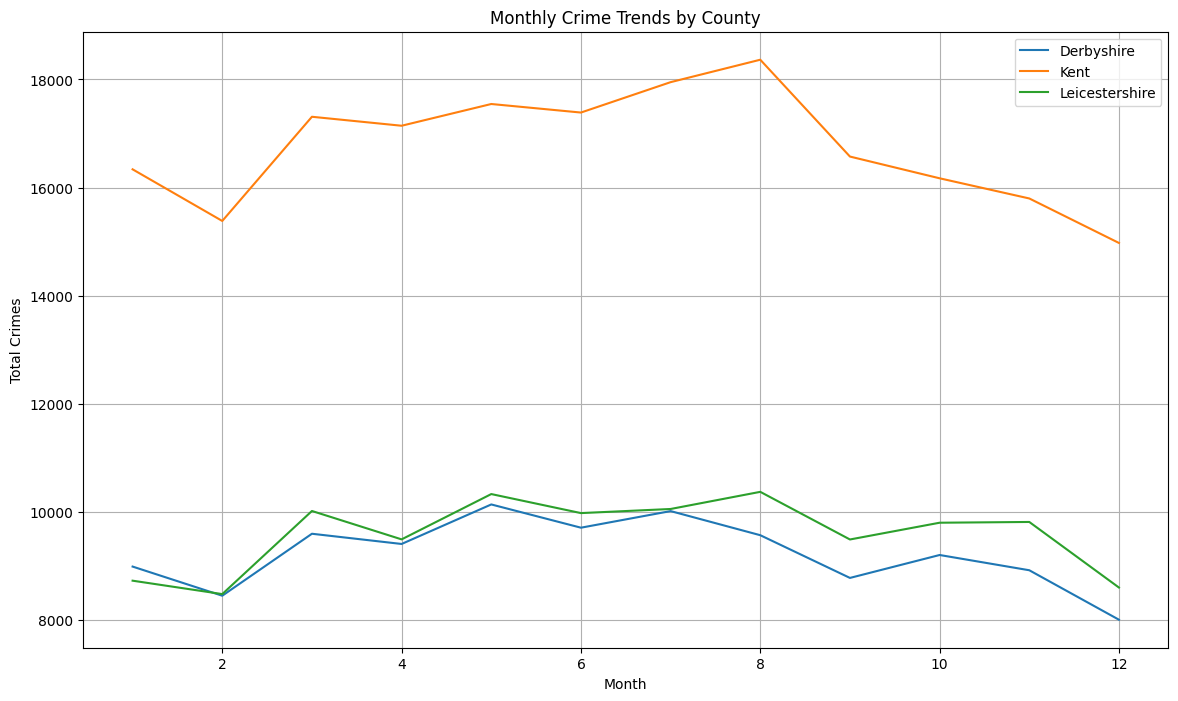

In [17]:
# step 12 : Line plot for Monthly Crime Trends

# Convert Spark DataFrame to Pandas DataFrame for easier plotting
monthly_crime_trends_pd = monthly_crime_trends.toPandas()

plt.figure(figsize=(14, 8))

# Iterate through each unique county to plot their respective data
for county in monthly_crime_trends_pd['County'].unique():
    county_data = monthly_crime_trends_pd[monthly_crime_trends_pd['County'] == county]
    plt.plot(county_data['Month'], county_data['Total_Crimes'], label=county)

plt.title('Monthly Crime Trends by County')
plt.xlabel('Month')
plt.ylabel('Total Crimes')
plt.legend()
plt.grid(True)
plt.show()

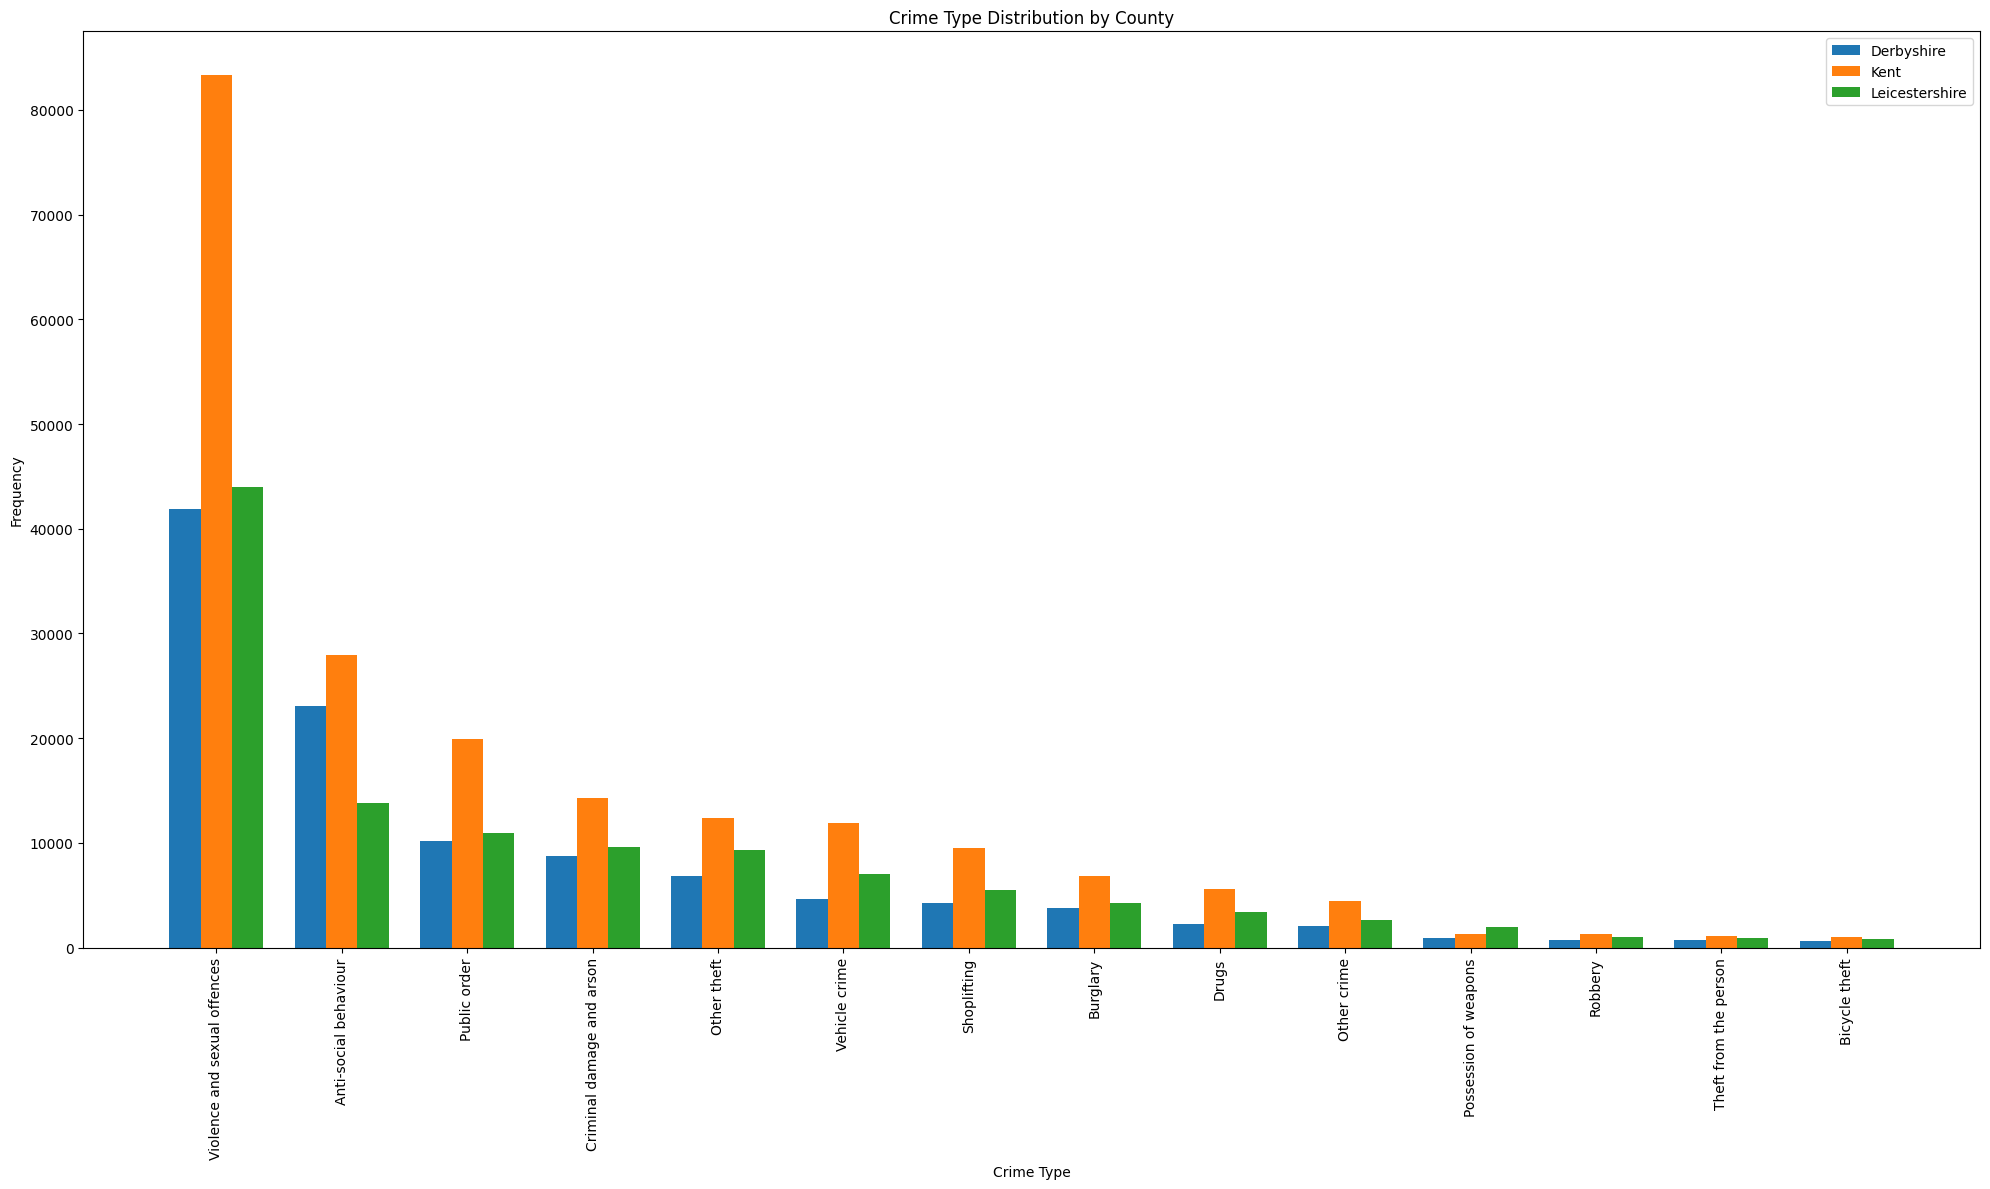

In [18]:
# Step 13 : Bar chart for crime type comparison

# Convert Spark DataFrame to Pandas DataFrame for easier plotting
crime_type_analysis_pd = crime_type_analysis.toPandas()
plt.figure(figsize=(20, 12))
width = 0.25  # Width of the bars
x = np.arange(len(crime_type_analysis_pd['Crime type'].unique()))  # Bar positions

# Iterate through each unique county and create a grouped bar chart
counties = crime_type_analysis_pd['County'].unique()
for i, county in enumerate(counties):
    county_data = crime_type_analysis_pd[crime_type_analysis_pd['County'] == county]
    plt.bar(x + i * width, county_data['Frequency'], width=width, label=county)

plt.xticks(x + width * (len(counties) - 1) / 2, crime_type_analysis_pd['Crime type'].unique(), rotation=90)
plt.title('Crime Type Distribution by County')
plt.xlabel('Crime Type')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

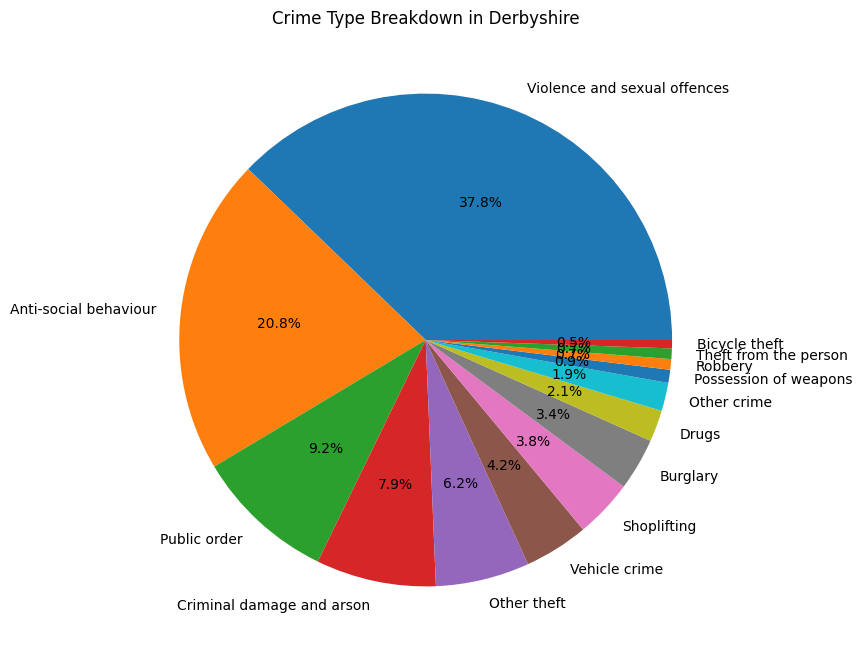

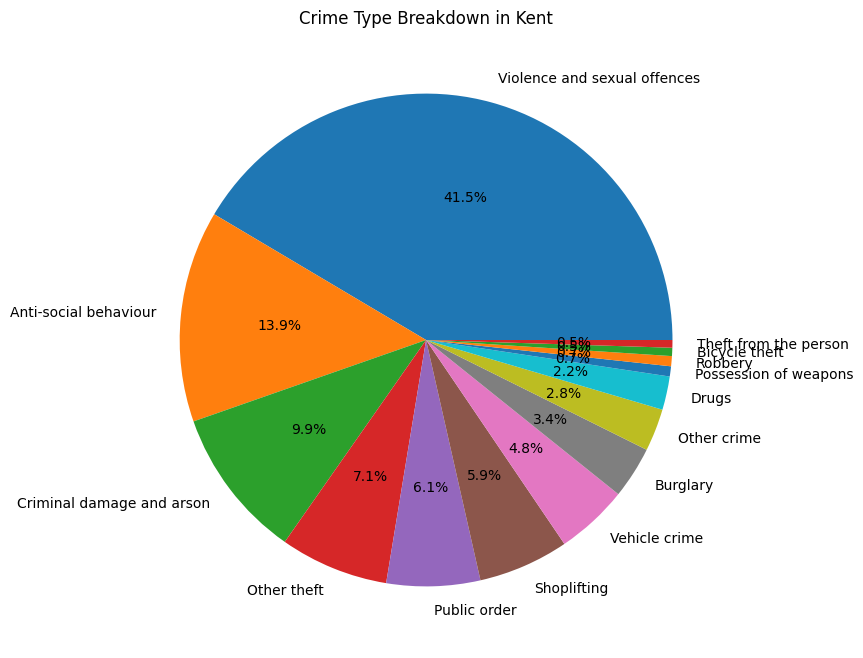

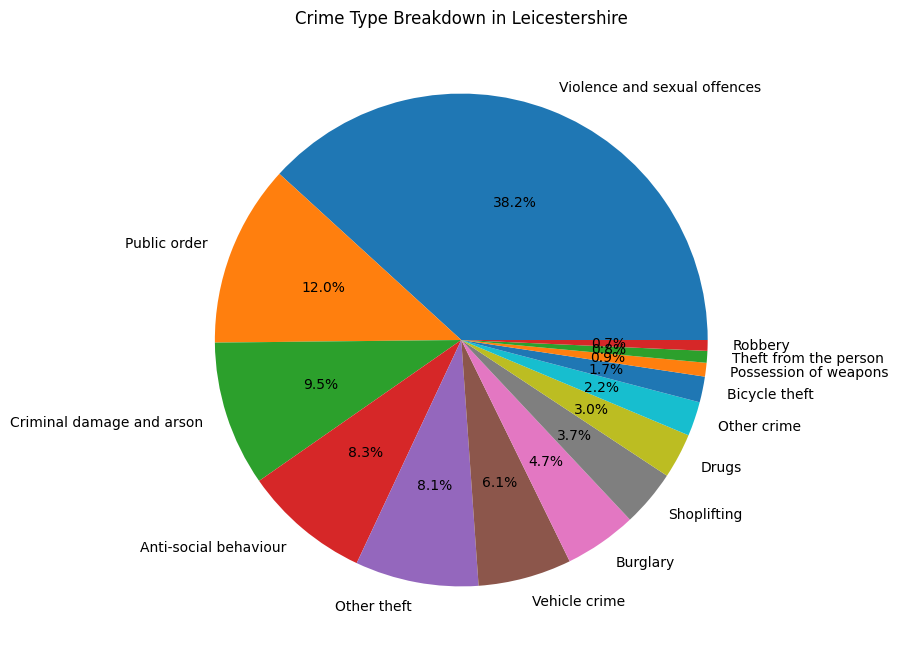

In [19]:
# Step 14 : Pie charts for crime type breakdown by county

# Iterate through each unique county to create a pie chart showing the crime type distribution
for county in crime_type_analysis_pd['County'].unique():
    county_data = crime_type_analysis_pd[crime_type_analysis_pd['County'] == county]
    plt.figure(figsize=(8, 8))
    plt.pie(county_data['Frequency'], labels=county_data['Crime type'], autopct='%1.1f%%')
    plt.title(f'Crime Type Breakdown in {county}')
    plt.show()
